In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from IPython.display import clear_output
import warnings
import os 
from glob import glob 
import pandas as pd 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#디렉토리 생성 

In [2]:
!mkdir -p ./thumb/train/up
!mkdir -p ./thumb/train/down
!mkdir -p ./thumb/test/up
!mkdir -p ./thumb/test/down

# 이미지 캡쳐 

In [3]:
def take_photo(last_file_path, quality=1.0):

    js = Javascript('''

        async function takePhoto([last_file_path, quality]) {

            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            video.height = 224
            video.width = 224
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            // google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);


            const capture = document.createElement('button');
            const train_up = document.createElement('button')
            const train_down = document.createElement('button');
            const test_up = document.createElement('button');
            const test_down = document.createElement('button');

            capture.textContent = 'Capture';
            train_up.textContent = 'Train/up';
            train_down.textContent = 'Train/Down';
            test_up.textContent = 'Test/Up';
            test_down.textContent = 'Test/Down';

            div.appendChild(capture);
            div.appendChild(train_up);
            div.appendChild(train_down);
            div.appendChild(test_up);
            div.appendChild(test_down);
            
            file_path = last_file_path
            train_up.onclick   = function(){ file_path = './thumb/train/up' }
            train_down.onclick = function(){ file_path = './thumb/train/down' }
            test_up.onclick    = function(){ file_path = './thumb/test/up' }
            test_down.onclick  = function(){ file_path = './thumb/test/down' }

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            // canvas.width = video.videoWidth;
            // canvas.height = video.videoHeight;
            canvas.width = 224;
            canvas.height = 224;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            
            return [canvas.toDataURL('image/jpeg', quality), file_path];
        }
        
    ''')

    display(js)

    data, file_path = eval_js('takePhoto({})'.format([last_file_path, quality]))
    binary = b64decode(data.split(',')[1])
    return binary, file_path


In [4]:
def find_max_index(file_path):
    import re
    file_names = glob(file_path)
    # file_names = ['Picture 03.jpg', '02.jpg', '1.jpg']
    if len(file_names)==0: return 0

    file_indexes = [int(re.sub('\D','',file_name)) for file_name in file_names]
    # file_indexes = [3, 2, 1]

    max_value = max(file_indexes)
    # max_value = 3
    return max_value

max_index = find_max_index('./thumb/train/up/*')
print(max_index)

0


In [5]:
last_file_path = "./thumb/train/up"
while(True):
  binary, file_path = take_photo(last_file_path)
  max_index += 1
  file_name = f'{file_path}/image{max_index}.jpg'
  
  with open(file_name,'wb') as f:
    f.write(binary)
#   print(file_name)
  last_file_path = file_path


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

# 모델 학습

31801344/31790344 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 256)               17662208  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 25,432,315
Trainable params: 17,663,234
Non

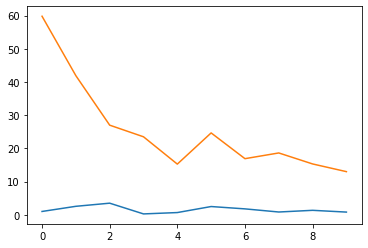

1/1 [==============================] - 0s 59ms/step - loss: 12.9923 - acc: 0.5000
loss= 12.992319107055664
acc= 0.5


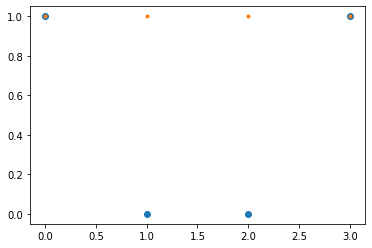

label category index = 1.0
predicted category index = 1
predicted category name = up


In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "thumb/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "thumb/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


# 모델 저장

In [7]:
model.save("thumb.h5")

In [8]:
!ls -alh

total 165M
drwxr-xr-x 1 root root 4.0K Jul 21 13:36 .
drwxr-xr-x 1 root root 4.0K Jul 21 13:32 ..
drwxr-xr-x 4 root root 4.0K Jul 13 13:42 .config
drwxr-xr-x 1 root root 4.0K Jul 13 13:43 sample_data
drwxr-xr-x 4 root root 4.0K Jul 21 13:34 thumb
-rw-r--r-- 1 root root 165M Jul 21 13:36 thumb.h5


copy from https://www.youtube.com/watch?v=YjWh7QvVH60

In [9]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [10]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [11]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          '끝내려면 여기를 클릭하세요.</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, overay_img):
  data = eval_js('stream_frame("{}", "{}")'.format(label, overay_img))
  return data

# 모델 로딩

In [12]:
import tensorflow

model = tensorflow.keras.models.load_model("thumb.h5")

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class Classifier:

    def classify(self, image):
        
        predicted = model.predict(np.expand_dims(image, axis=0))
        return np.argmax(predicted, axis=1)[0]

classifier = Classifier()

In [16]:
# start streaming video from webcam
video_stream()

# label for video
result = 'Capturing...'

# initialze bounding box to empty
overray_bytes = ''
count = 0 
class_name = { 0:"up", 1:"down" }

while True:
    js_reply = video_frame(result, overray_bytes)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    img = cv2.resize(img, (224, 224))

    category = classifier.classify(img)
    # print(f"thumb : {class_name[category]}")

    # create transparent overlay for bounding box
    overray_img = np.zeros([480,640,4], dtype=np.uint8)
    cv2.putText(overray_img, class_name[category], (240,320), cv2.FONT_HERSHEY_SIMPLEX, 10, 255)

    # convert overlay of bbox into bytes
    overray_bytes = bbox_to_bytes(overray_img)
    result = class_name[category]
    


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored